In [6]:
import numpy as np
from scipy import stats as sts
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency

Постановка задачи
Необходимо смоделировать 2 количественных признака для трех случаев:

X, Y - гауссовское распределение, имеют монотонную зависимость
X, Y - негауссовское распределение, имеют линейную монотонную зависимость
X, Y - негауссовское распределение, имеют неоинейную немонотонную зависимость

Для полученных данных проверить гипотезу о зависимости признаков тремя критериями:

Выборочный коэффициент корреляции
Критерий спирмана
Критерий Хи-квадрат Пирсона
Вычислить частоту ошибок второго рода для каждого случая и сравнить полученные результаты.

Функции генерации выборок

In [33]:
def gaussian_linear_monotone(mu, sigma, n):
    x = np.random.normal(mu, sigma, n)
    y = 0.4 * x + 0.6 * np.random.normal(mu, sigma, n)
    return x, y

def notgaussian_notlinear_monotone(mu, sigma, n):
    x = np.random.normal(mu, sigma, n)
    y = np.exp(0.004 * x) + 0.08 * x + np.random.normal(mu * 2, sigma * 10, n)
    return x, y

def notgaussian_notlinear_notmonotone(mu, sigma, n):
    x = np.random.normal(mu, sigma, n)
    y = 0.00009 * np.sin(x)+ 0.02 * np.sin(np.random.normal(mu, sigma, n))
    return x, y

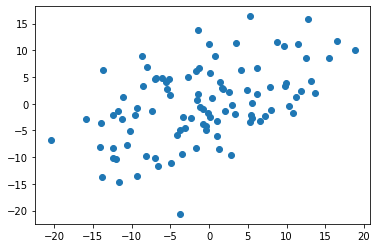

In [34]:
x1, y1 = gaussian_linear_monotone(0, 10, 100)
plt.scatter(x1, y1)

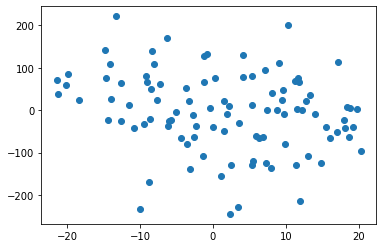

In [35]:
x2, y2 = notgaussian_notlinear_monotone(0, 10, 100)
plt.scatter(x2, y2)

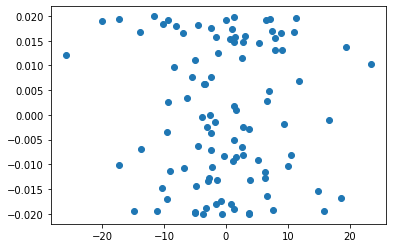

In [36]:
x3, y3 = notgaussian_notlinear_notmonotone(0, 10, 100)
plt.scatter(x3, y3)

Выборочный коэффициент корреляции

In [56]:
def correlation_test(x, y, alpha=0.05):
    n = len(x)
    x_mean = x.mean()
    y_mean = y.mean()

    # Pearson’s correlation coefficient.
    r = (1/n * np.sum((x - x_mean)*(y - y_mean))) / (1/n*np.sum((x - x_mean)**2) * 1/n*np.sum((y - y_mean)**2))**0.5
    t = n ** 0.5 * r
    # Two-tailed p-value
    p_value = np.min(np.array([2 * sts.norm.cdf(t), 2 - 2 * sts.norm.cdf(t)]), axis=0)
    if (p_value > alpha / 2) and (p_value < (1 - alpha / 2)):
        h0 = 0 # Accept H0
    else:
        h0 = 1 # Reject H0
    return r, p_value, h0

In [58]:
print(correlation_test(x1, y1))
sts.pearsonr(x1, y1)

(0.49292717213363874, 8.25367137302635e-07, 1)


(0.4929271721336387, 1.8886327477096312e-07)

In [59]:
print(correlation_test(x2, y2))
sts.pearsonr(x2, y2)

(-0.23571756867081395, 0.01841453243636595, 1)


(-0.23571756867081395, 0.01823011500953986)

In [60]:
print(correlation_test(x3, y3))
sts.pearsonr(x3, y3)

(-0.02113004662649407, 0.8326528191108498, 0)


(-0.02113004662649409, 0.8347080635116283)

Критерий спирмана

In [103]:
def spearman(x, y, alpha=0.05):
    n = len(x)
    x_ranks = sts.rankdata(x)
    y_ranks = sts.rankdata(y)

    s = np.sum((x_ranks - y_ranks)**2)
    # Spearman correlation coefficient
    r = 1 - 6*s/(n**3 - n)
    t = (n-1)**0.5 * r
    p_value = np.min(np.array([2 * sts.norm.cdf(t), 2 - 2 * sts.norm.cdf(t)]), axis=0)
    if (p_value > alpha / 2) and (p_value < (1 - alpha / 2)):
        h0 = 0 # Accept H0
    else:
        h0 = 1 # Reject H0
    return r, p_value, h0

In [104]:
print(spearman(x1, y1))
print(sts.spearmanr(x1, y1))

(0.463966396639664, 3.904401947751879e-06, 1)
SpearmanrResult(correlation=0.46396639663966394, pvalue=1.1629094496771656e-06)


In [63]:
print(spearman(x2, y2))
print(sts.spearmanr(x2, y2))

(-0.2572337233723372, 0.010483997721181804, 1)
SpearmanrResult(correlation=-0.2572337233723372, pvalue=0.009776720961015685)


In [64]:
print(spearman(x3, y3))
print(sts.spearmanr(x3, y3))

(0.01098109810981096, 0.9129958384108221, 0)
SpearmanrResult(correlation=0.010981098109810981, pvalue=0.9136517171776963)


Критерий Хи-квадрат Пирсона

Критерий Хи-квадрат Пирсона используется, если признаки ненормальны, подозревается
немонотонная нелинейная зависимость.

In [76]:
def to_nominal(x, k):
    x_sort = np.sort(x)
    x_in_scale = np.zeros(k)
    slices = np.linspace(x_sort[0], x_sort[-1], k+1)
    for i in range(k):
        x_part = x[x >= slices[i]]
        x_count = (x_part <= slices[i+1]).sum()
        x_in_scale[i] = x_count
    return x_in_scale

In [77]:
def pirson(x, y, alpha=0.05):
    n = len(x)
    x_nom, y_nom = to_nominal(x, 5), to_nominal(y, 5)
    matrix = np.concatenate(([x_nom], [y_nom]))
    chi_square_value = 0

    for i in range(2):
        for j in range(len(x_nom)):
            chi_square_value += (matrix[i][j] - (np.sum(matrix[i]) * np.sum(matrix[:,j]) / np.sum(matrix))) ** 2 \
            / (np.sum(matrix[i]) * np.sum(matrix[:,j]) / np.sum(matrix))

    # Cumulative distribution function
    p_value = 1 - sts.chi2.cdf(chi_square_value, (len(x_nom) - 1))
    if p_value > alpha:
        h0_true = 0 # Accept H0
    else:
        h0_true = 1 # Reject H0
    return chi_square_value, p_value, h0_true

In [82]:
print(pirson(x1, y1))
chi2_contingency([to_nominal(x1, 5), to_nominal(y1, 5)])

# - chi2float
#       The test statistic.

# - pfloat
#       The p-value of the test

# - dofint
#       Degrees of freedom

# - expected
#       The expected frequencies, based on the marginal sums of the table.

(7.120186896039078, 0.12967158012997693, 0)


(7.120186896039078,
 0.12967158012997695,
 4,
 array([[ 5. , 21.5, 36.5, 27. , 10. ],
        [ 5. , 21.5, 36.5, 27. , 10. ]]))

In [83]:
print(pirson(x2, y2))
chi2_contingency([to_nominal(x2, 5), to_nominal(y2, 5)])

(10.916071640777524, 0.02752362364608263, 1)


(10.916071640777524,
 0.027523623646082622,
 4,
 array([[ 8.5, 20. , 31.5, 27.5, 12.5],
        [ 8.5, 20. , 31.5, 27.5, 12.5]]))

In [84]:
print(pirson(x3, y3))
chi2_contingency([to_nominal(x3, 5), to_nominal(y3, 5)])

(57.63709273182958, 9.09394781700712e-12, 1)


(57.63709273182958,
 9.093913205533452e-12,
 4,
 array([[15. , 17. , 31.5, 17.5, 19. ],
        [15. , 17. , 31.5, 17.5, 19. ]]))

Подсчёт ошибок 2-го рода

In [88]:
def beta_errors(num_experiments, f, mu, sigma, size):
    correlation  = []
    spearman_res = []
    pirson_res   = []
    for i in range(num_experiments):
        x, y = f(mu, sigma, size)
        correlation.append(correlation_test(x, y)[2])
        spearman_res.append(spearman(x, y)[2])
        pirson_res.append(pirson(x, y)[2])

    cor_freq        = (num_experiments - sum(correlation))  / num_experiments
    spearman_freq   = (num_experiments - sum(spearman_res)) / num_experiments
    pirson_freq     = (num_experiments - sum(pirson_res))   / num_experiments
    
    return cor_freq, spearman_freq, pirson_freq

In [89]:
mu    = 5
sigma = 10
size  = 100

In [101]:
cor_freq, spearman_freq, chi2_pirson_freq = beta_errors(1000, gaussian_linear_monotone, mu, sigma, size)
print("gaussian_linear_monotone")
print("correlation_test=", cor_freq)
print("spearman_test=", spearman_freq)
print("chi2_pirson_test=", chi2_pirson_freq)


gaussian_linear_monotone
correlation_test= 0.0
spearman_test= 0.001
chi2_pirson_test= 0.636


In [97]:
cor_freq, spearman_freq, pirson_freq = beta_errors(1000, notgaussian_notlinear_monotone, mu, sigma, size)
print("notgaussian_notlinear_monotone")
print("correlation_test=", cor_freq)
print("spearman_test=", spearman_freq)
print("chi2_pirson_test=", chi2_pirson_freq)

notgaussian_notlinear_monotone
correlation_test= 0.947
spearman_test= 0.951
pirson_test= 0.555


In [102]:
cor_freq, spearman_freq, chi2_pirson_freq = beta_errors(1000, notgaussian_notlinear_notmonotone, mu, sigma, size)
print("notgaussian_notlinear_notmonotone")
print("correlation_test=", cor_freq)
print("spearman_test=", spearman_freq)
print("chi2_pirson_test=", chi2_pirson_freq)

notgaussian_notlinear_notmonotone
correlation_test= 0.955
spearman_test= 0.95
chi2_pirson_test= 0.0
